In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [3]:
df = pd.read_csv('/home/jupyter-a-berezin-18/Statistics/hw_bootstrap.csv', sep = ';')

In [4]:
def num(n):
    a = n.replace(',', '.')
    return a

In [5]:
df['value'] = df.value.apply(num)

In [6]:
df['value'] = df.value.astype({'value': 'float'})

Распределение группы Control

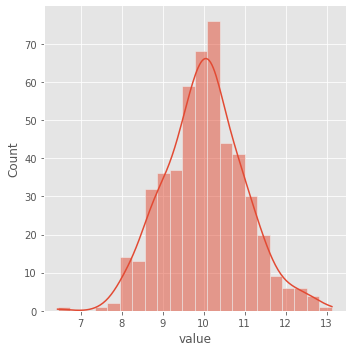

In [7]:
sns.displot(df[df.experimentVariant == 'Control']['value'], kde = True)

Распределение выглядит нормально

Распределение группы Treatment

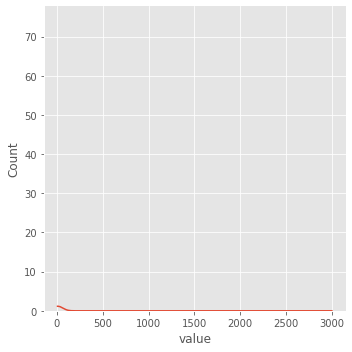

In [8]:
sns.displot(df[df.experimentVariant == 'Treatment']['value'], kde = True)

В группе есть выбросы

In [9]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return { 
            "ci": ci, 
            "p_value": p_value}

Нулевая гипотеза: Различий в наших группах нет

Альтернативная гипотеза: Различия есть

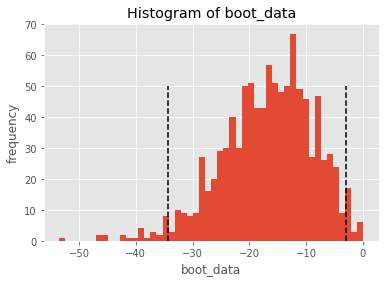

{'ci':                0
 0.025 -34.261486
 0.975  -3.055245,
 'p_value': 0.03773948338431551}

In [10]:
get_bootstrap(
    df[df.experimentVariant == 'Control']['value'],
    df[df.experimentVariant == 'Treatment']['value'],
    boot_it = 1000,
    statistic = np.mean, 
    bootstrap_conf_level = 0.95)

p_value < 0,05 нулевую гипотезу отклоняем

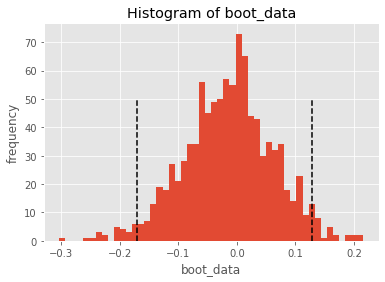

{'ci':               0
 0.025 -0.170722
 0.975  0.127448,
 'p_value': 0.8568663086646285}

In [11]:
get_bootstrap(
    df[df.experimentVariant == 'Control']['value'],
    df[df.experimentVariant == 'Treatment']['value'],
    boot_it = 1000,
    statistic = np.median, 
    bootstrap_conf_level = 0.95)

p_value > 0,05 нулевую гипотезу принимаем

In [12]:
mannwhitneyu(df[df.experimentVariant == 'Control']['value'], df[df.experimentVariant == 'Treatment']['value'])

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

p_value > 0,05 нулевую гипотезу принимаем

Бутстрап(mean) говорит что различия в наших группах есть и в чем-то он прав, ведь во второй группе есть выбросы. Но бутстрап(median) сказал что наши группы равны, в них нет изменений, а критерий Манна-Уитни с ним согласился т.к не чувствителен к отклонениям.
Думаю лучше использовать бутстрап(median).